We are going to solve the following polynomial eigenvalue problem using finite element method,
$$ -\Omega^2\tilde{v} + 2\Omega v_0\frac{\partial}{\partial z}\tilde{v} + (1-v_0^2)\frac{\partial^2}{\partial z^2}\tilde{v} = 0 $$

Assume $\tilde{v}(z) = \sum_{j=-N}^N q_j\phi_j(z)$, where $\phi_j(z)$ is the tent function peaks at $x=j\Delta x$. Left multiply $\phi_i(z)$ on both sides of the equation, then take the inner product,

$$ \sum_{j=-N}^N \left[ -\Omega^2 (\phi_i,\phi_j)  + 2\Omega v_0 (\phi_i,\phi_j') - (1-v_0^2)(\phi_i',\phi_j') \right]q_j = 0 $$
where $(\cdot,\cdot)$ denotes the inner product.

Let $A_2=-(\phi_i,\phi_j)$, $A_1=2v_0(\phi_i,\phi_j')$, and $A_0=-(1-v_0^2)(\phi_i',\phi_j')$. Denote $\mathbf{q} = [q_{-N}, q_{-N+1}, ..., q_{N-1}, q_{N}]^T$. We have a polynomial eigenvalue problem
$$ (\Omega^2 A_2 + \Omega A_1 + A_0)\mathbf{q} = \mathbf{0} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions import polyeig, Spectral
from scipy.special import lambertw

W = lambda z,k: np.real(lambertw(z,k=k)) # I only need the real parts

In [41]:
def velocity_profile(M, Mm, x, method, constant_velocity=False,acclerting=True):
    if constant_velocity:
        v = Mm*np.ones_like(x) # constant v=0.1
        return v

    if Mm < 1:
        v = M(x, Mm=Mm, k=0) # subsonic velocity profile, M_m = 0.1
    elif Mm == 1:
        if method == "FD":
            if acclerting:
                v = np.concatenate([M(x[x<0], Mm=1, k=0), [1], M(x[x>0], Mm=1, k=-1)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x<0], Mm=1, k=-1), [1], M(x[x>0], Mm=1, k=0)]) # decelerating velocity profile
        elif method == "CH":
            if acclerting:
                v = np.concatenate([M(x[x>0], Mm=1, k=-1), M(x[x<0], Mm=1, k=0)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x>0], Mm=1, k=0), M(x[x<0], Mm=1, k=-1)]) # decelerating velocity profile
    else:
        v = M(x, Mm=Mm, k=-1) # supersonic velocity profile
    return v

def evaluate_single(x: float, q: np.array):
    """ evaluate the solution at x """
    # need to shift x to [0,2] rather than [-1,1]
    j = int((x+1)/dx) 
    q_j = q[j] # get the coefficient at j
    q_jp1 = q[j+1] if j<2*N else 0 # get the coefficient at j+1
    j -= N # then shift the index to [-N,N]
    phi_j = (j+1) - x/dx # phi_j in [jdx,(j+1)dx]
    phi_jp1 = x/dx - j # phi_{j+1} in [jdx,(j+1)dx]
    return q_j*phi_j + q_jp1*phi_jp1
    
evaluate = np.vectorize(evaluate_single, excluded=[1])

In [112]:
N = 100
domain = "symmetric"
method = "FD"
spectral = Spectral(2*N+1,domain,method)

# magnetic field, B, and velocity profile, M
B0 = 1
R = 1.5
Bm = 1+R
Delta = 0.1/0.3
B = lambda z: B0*(1+R*np.exp(-(z/Delta)**2))

# k=-1: supersonic branch
# k=0: subsonic branch
M = lambda z, Mm, k: np.sqrt( -W(-Mm**2 * (B(z)/Bm)**2 * np.exp(-Mm**2), k=k) )

x = spectral.x
dx = x[1]-x[0]
Mm = 1.5
acclerting = False
constant_velocity = True
v0 = velocity_profile(M,Mm,x,method,constant_velocity,acclerting)

In [118]:
ones = np.ones(2*N+1)
A2 = -(np.diag(4*ones,k=0) + np.diag(4*ones[1:],k=1) + np.diag(4*ones[1:],k=-1))*dx/6
A1 = 2*np.diag(v0)@(np.diag(1*ones[1:],k=1) + np.diag(-1*ones[1:],k=-1))/2
A0 = -np.diag((1-v0**2))@(np.diag(2*ones,k=0) + np.diag(-1*ones[1:],k=1) + np.diag(-1*ones[1:],k=-1))/dx

V,e = polyeig(A0,A1,A2)
omega = -1j*e

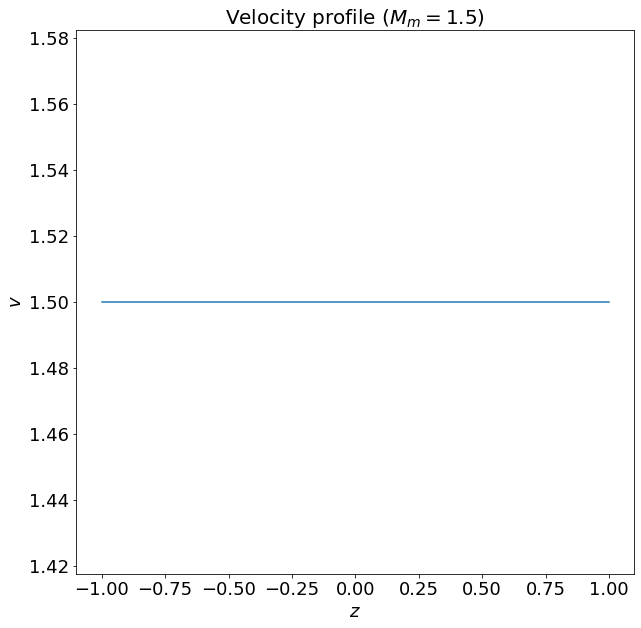

In [119]:
# velocity profile
plt.figure()
plt.plot(x, v0)
plt.title(f"Velocity profile ($M_m={Mm}$)")
plt.xlabel("$z$")
plt.ylabel("$v$");

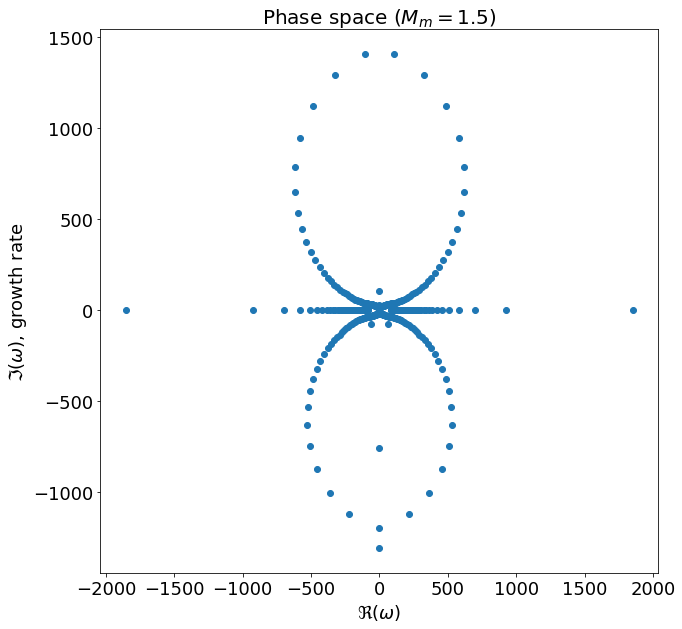

In [120]:
# phase space
plt.figure()
selection = (np.abs(np.real(omega))<100) & (np.abs(np.imag(omega))<1000)
omega_ = omega#[selection]

plt.plot(np.real(omega_), np.imag(omega_), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$, growth rate")
if (Mm == 1) & (acclerting):
    plt.title(f"Phase space ($M_m={Mm}$, accelerating)");
elif (Mm == 1) & (not acclerting):
    plt.title(f"Phase space ($M_m={Mm}$, decelerating)");
else:
    plt.title(f"Phase space ($M_m={Mm}$)");

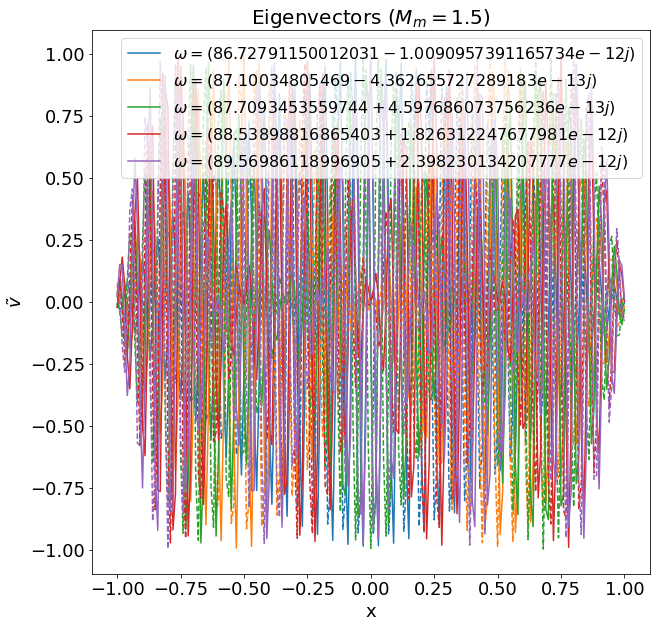

In [121]:
# eigenvectors
plt.figure()
selection = (np.real(omega)>=0) & (np.abs(np.imag(omega))<0.1) 
#selection = (np.real(omega) >=0)  & (np.abs(np.imag(omega))>0.1) 
omega_ = omega[selection]
V_ = V[:, selection]

ind = np.argsort(np.abs(np.real(omega_)))
omega_ = omega_[ind]
V_ = V_[:,ind]

size = 1 if omega_.size > 5 else omega_.size
for i in range(5):
    v = V_[:,i]
    v_real = np.real(v)#/np.abs(np.real(v)).max()
    v_imag = np.imag(v)#/np.abs(np.imag(v)).max()
    #y = evaluate(x,np.real(v))
    lines = plt.plot(spectral.x, v_real, label=f"$\omega={omega_[i]}$")
    plt.plot(spectral.x, v_imag, '--', color=lines[0]._color)
plt.xlabel("x")
plt.ylabel("$\\tilde{v}$")
plt.title(f"Eigenvectors ($M_m={Mm}$)")
plt.legend();

In [106]:
np.pi*(1-v0[0]**2)/2*np.arange(10)

array([ 0.        ,  1.17809725,  2.35619449,  3.53429174,  4.71238898,
        5.89048623,  7.06858347,  8.24668072,  9.42477796, 10.60287521])